In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"E:\Work\Upshifters Task\sentiment task - Sheet1.csv")
df = df.dropna()
df

,Text,label
0,راىع,Positive
1,روعه,Positive
2,جمييل,Positive
3,حلمي💔,Neutral
4,احبكم,Positive
...,...,...
1514,نبغي قرض الله يجزآكم خير ولا حولنا لبنك آخر,Mixed
1515,شكرا بارك الله فيك بس الأسعار غير موجودة\nعلى ...,Mixed
1516,شماغ ممتاز 👌🏽. بس مارح اشتري منكم. 👎🏼 علان تعبان,Negative
1517,قسط مرتفع نتمنى تخفيض تحت ١٠٠٠ الاسعار عالية ج...,Negative


# No Pre-processing with UBC-NLP/MARBERTv2 splitting train/val/test

# Run 3

In [3]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

X = df['Text']
y = df['label_encoded']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Using AraBERT, MARBERT, or mBERT for feature extraction and fine-tuning
model_name = "UBC-NLP/MARBERTv2"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Tokenize the text
def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=128)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Create torch datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, y_train.tolist())
val_dataset = SentimentDataset(val_encodings, y_val.tolist())
test_dataset = SentimentDataset(test_encodings, y_test.tolist())

# Fine-tune the model
training_args = TrainingArguments(
    output_dir='./results_best_model_2',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_best_model_2',
    logging_steps=10,
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [6]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.172100,1.084259
2,0.704500,0.641260
3,0.465400,0.569875
4,0.452100,0.619662
5,0.341500,0.718791


TrainOutput(global_step=380, training_loss=0.7055539143712897, metrics={'train_runtime': 76.0483, 'train_samples_per_second': 79.883, 'train_steps_per_second': 4.997, 'total_flos': 259120223083800.0, 'train_loss': 0.7055539143712897, 'epoch': 5.0})

Validation Set Evaluation:
Accuracy: 0.7763157894736842
Precision: 0.7816390330240747
Recall: 0.7763157894736842
F1 Score: 0.7639118793042605
Confusion Matrix:
[[ 0  2  0  0]
 [ 0 55  4  1]
 [ 0 16 32  7]
 [ 0  3  1 31]]
Test Set Evaluation:
Accuracy: 0.7960526315789473
Precision: 0.7767738674417135
Recall: 0.7960526315789473
F1 Score: 0.7844316875319366
Confusion Matrix:
[[ 0  2  1  0]
 [ 0 57  3  0]
 [ 0  9 37  8]
 [ 0  0  8 27]]


C:\Users\Rana Waly\.conda\envs\new_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rana Waly\.conda\envs\new_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


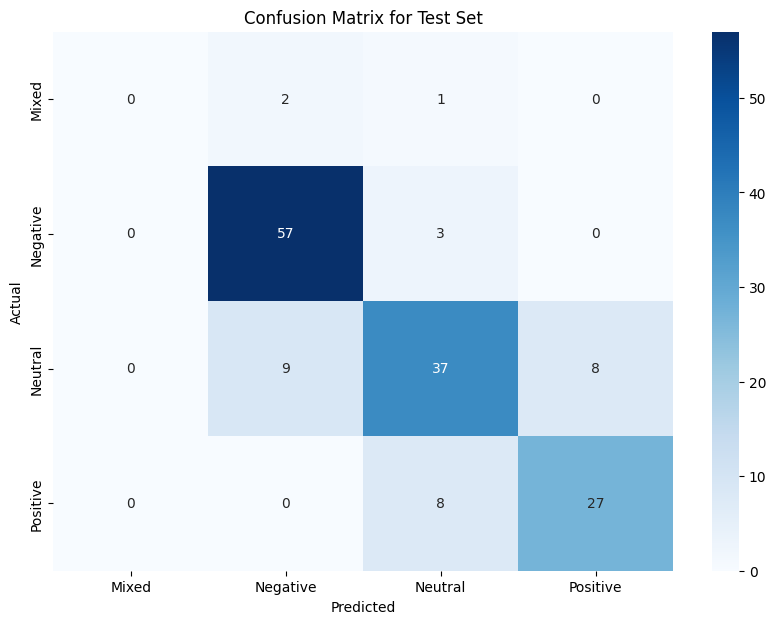

In [7]:
# Evaluate on validation set
val_preds = trainer.predict(val_dataset)
val_pred_labels = torch.argmax(torch.tensor(val_preds.predictions), axis=1)

# Evaluate on test set
test_preds = trainer.predict(test_dataset)
test_pred_labels = torch.argmax(torch.tensor(test_preds.predictions), axis=1)

# Evaluation metrics
val_accuracy = accuracy_score(y_val, val_pred_labels)
val_precision = precision_score(y_val, val_pred_labels, average='weighted')
val_recall = recall_score(y_val, val_pred_labels, average='weighted')
val_f1 = f1_score(y_val, val_pred_labels, average='weighted')
val_cm = confusion_matrix(y_val, val_pred_labels)

test_accuracy = accuracy_score(y_test, test_pred_labels)
test_precision = precision_score(y_test, test_pred_labels, average='weighted')
test_recall = recall_score(y_test, test_pred_labels, average='weighted')
test_f1 = f1_score(y_test, test_pred_labels, average='weighted')
test_cm = confusion_matrix(y_test, test_pred_labels)

# Print validation metrics
print("Validation Set Evaluation:")
print(f"Accuracy: {val_accuracy}")
print(f"Precision: {val_precision}")
print(f"Recall: {val_recall}")
print(f"F1 Score: {val_f1}")
print(f"Confusion Matrix:\n{val_cm}")

# Print test metrics
print("Test Set Evaluation:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")
print(f"Confusion Matrix:\n{test_cm}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Set')
plt.show()

In [8]:
model.save_pretrained('./results_best_model_2')
tokenizer.save_pretrained('./results_best_model_2')

('./results_best_model_2\\tokenizer_config.json',
 './results_best_model_2\\special_tokens_map.json',
 './results_best_model_2\\vocab.txt',
 './results_best_model_2\\added_tokens.json',
 './results_best_model_2\\tokenizer.json')

# Load the saved model

In [4]:
#Some test cases
# [
#     {"text": "شلون اتواصل مع خدمة العملاء عندي شكوى"},
#     {"text": "الف مبروك، ويستاهلون وعقبالي بإذن الله 😭🤲🤍🌙"},
#     {"text": "طبعاً سيارة جملية بزمنها كانت هي الأفضل ألا ليت الزمان يعود يوماً 🇸🇦"},
#     {"text": "عود ارين مستخرج من جزيره ارين في دوله اندونيسيا حيث يتم انتقاء العود بعنايه لتغير رائحه المكان 🌸#حاضر_وموجود"}
# ]

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained('./results_best_model_2')
tokenizer = AutoTokenizer.from_pretrained('./results_best_model_2')

In [3]:
import torch
from transformers import Trainer, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder

# Label encoder setup
le = LabelEncoder()
le.fit(["mixed", "negative", "neutral", "positive"])   # Adjust based on your classes

# Define your new data
new_texts = ["""الف مبروك، ويستاهلون
وعقبالي بإذن الله 😭🤲🤍🌙"""]

# Tokenize the new data
new_encodings = tokenizer(new_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Create a simple dataset class for the new data
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create the dataset
new_dataset = SimpleDataset(new_encodings)

# Create a trainer with the same training arguments
trainer = Trainer(
    model=model
)

# Make predictions
predictions = trainer.predict(new_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()

# Decode the predicted labels
predicted_class_names = le.inverse_transform(predicted_labels)

# Print the texts along with their predicted labels
for text, label in zip(new_texts, predicted_class_names):
    print(f"Text: {text}")
    print(f"Predicted Label: {label}")


Text: الف مبروك، ويستاهلون
وعقبالي بإذن الله 😭🤲🤍🌙
Predicted Label: positive
